In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import re
from pathlib import Path
from statistics import mean

In [2]:
# Read in the data
_DATA_DIR = "./data"
_dataset_loan_columns = ["loan_amnt", 
                         "int_rate", 
                         "term", "grade", 
                         "sub_grade", 
                         "installment", 
                         "annual_inc", 
                         "revol_bal",
                         "revol_util",
                         "loan_status", 
                         "verification_status", 
                         "title", "purpose", 
                         "emp_title", 
                         "addr_state", 
                         "zip_code"]

dataset_loans = {}
for file_name in os.listdir(_DATA_DIR):
    if file_name.endswith(".csv"):
        full_file_path = _DATA_DIR + "/" + file_name
        print(full_file_path)
        loan_period = re.search(r'\d{4}Q[0-4]{1}', file_name).group(0)
        dataset_loans[loan_period] = pd.read_csv(full_file_path, usecols=_dataset_loan_columns)[_dataset_loan_columns]

./data/LoanStats_2016Q1.csv
./data/LoanStats_2016Q2.csv
./data/LoanStats_2016Q3.csv
./data/LoanStats_2016Q4.csv
./data/LoanStats_2017Q1.csv
./data/LoanStats_2017Q2.csv
./data/LoanStats_2017Q3.csv
./data/LoanStats_2017Q4.csv
./data/LoanStats_2018Q1.csv
./data/LoanStats_2018Q2.csv
./data/LoanStats_2018Q3.csv
./data/LoanStats_2018Q4.csv


In [3]:
# Gets the index of labels in the group
# Returns pandas.core.indexes.numeric.Int64Index
def get_indexes(groups:dict, labels:list):
    indexes = None
    for label in labels:
        if label in groups.groups:
            if indexes is None:
                indexes = groups.groups[label]
            else:
                indexes = indexes.union(groups.groups[label])
    return indexes

### Loan Count By Status 

In [4]:
_loan_status_labels = ["Current", "Fully Paid", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)", "Default", "Charged Off"]

In [5]:
# Calculate loan status to loan status count dict
loan_count_by_status_per_quarter = {x: [0] * len(dataset_loans) for x in _loan_status_labels}

for idx, df in enumerate(dataset_loans.values()):
    for k,v in df["loan_status"].value_counts().iteritems():
        loan_count_by_status_per_quarter[k][idx] = v

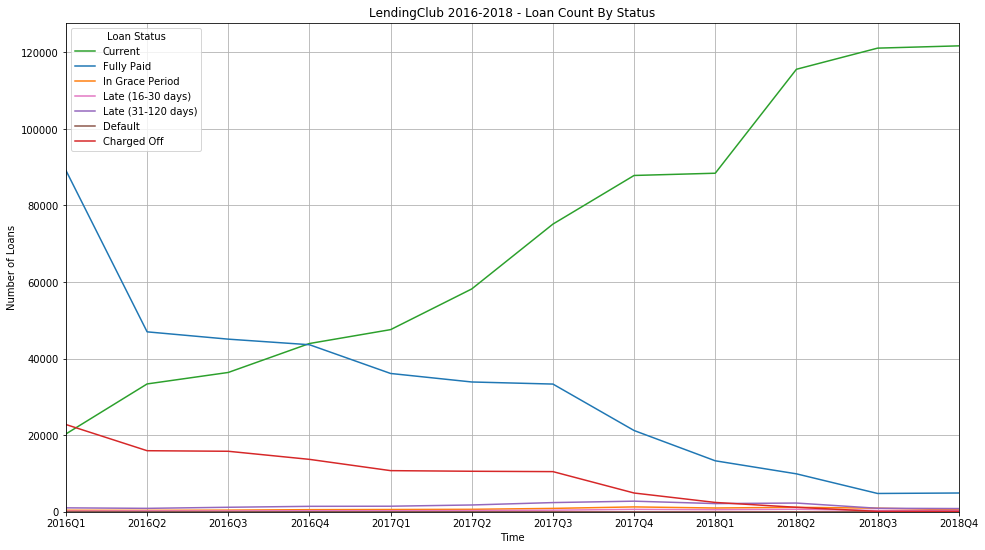

In [6]:
# Line plot of loan status count
plt.figure(figsize=(16,9))

colors = {
    "Current" : "#2ca02c",
    "Fully Paid": "#1f77b4",
    "In Grace Period" : "#ff7f0e",
    "Late (16-30 days)" : "#e377c2",
    "Late (31-120 days)" : "#9467bd",
    "Default": "#8c564b",
    "Charged Off": "#d62728"    
}

x = list(range(len(dataset_loans)))
for loan_status, loan_status_count_list in loan_count_by_status_per_quarter.items():
    plt.plot(x, loan_status_count_list, label=loan_status, color=colors[loan_status])
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Status")
plt.title("LendingClub 2016-2018 - Loan Count By Status")
plt.savefig("res/LendingClub 2016-2018 - Loan Count By Status Line Plot.png", bbox_inches='tight')
plt.show()

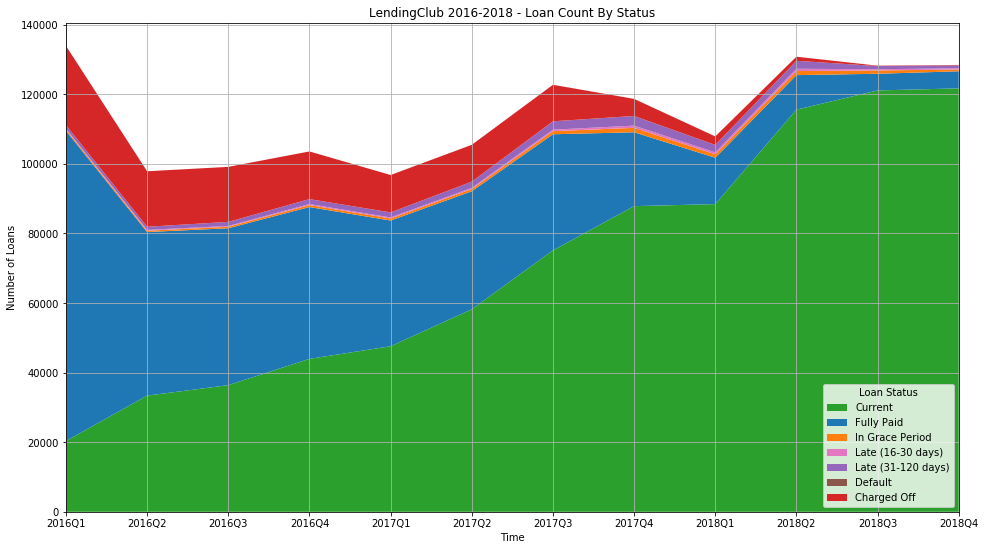

In [7]:
# Stacked area plot of loan status count
plt.figure(figsize=(16,9))

colors = {
    "Current"            : "#2ca02c",
    "Fully Paid"         : "#1f77b4",
    "In Grace Period"    : "#ff7f0e",
    "Late (16-30 days)"  : "#e377c2",
    "Late (31-120 days)" : "#9467bd",
    "Default"            : "#8c564b",
    "Charged Off"        : "#d62728"    
}

x = list(range(len(dataset_loans)))
plt.stackplot(x, *loan_count_by_status_per_quarter.values(), baseline="zero", labels=_loan_status_labels, colors=colors.values())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Status", loc=4)
plt.title("LendingClub 2016-2018 - Loan Count By Status")
plt.savefig("res/LendingClub 2016-2018 - Loan Count By Status Stacked Area Plot.png", bbox_inches='tight')
plt.show()

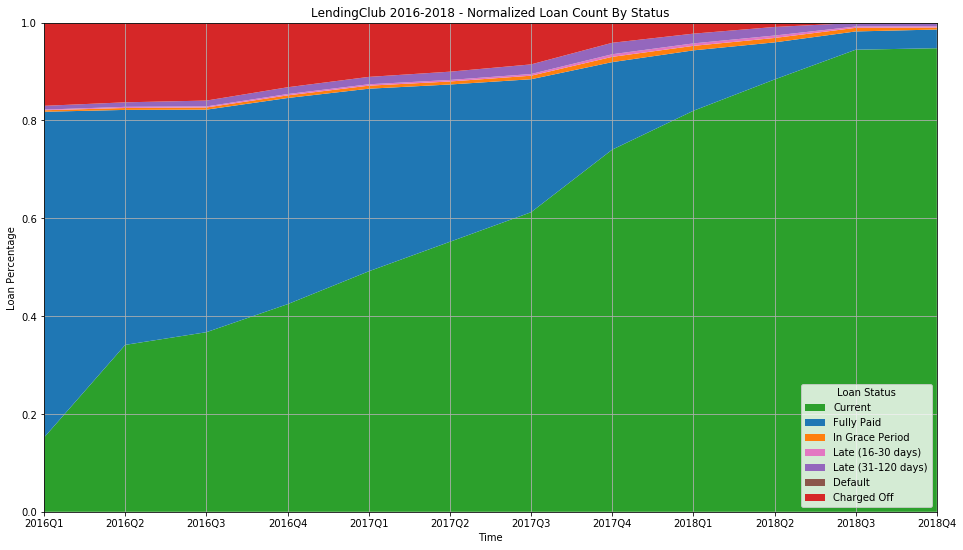

In [8]:
# Normalize loan status count
loan_status_percent_per_quarter = {loan_status: [loan_status_count / loan_status_count_total for loan_status_count, loan_status_count_total in zip(loan_status_count_list, [len(df) for df in dataset_loans.values()])] for loan_status, loan_status_count_list in loan_count_by_status_per_quarter.items()}

# Stacked area plot of normalized loan status count
plt.figure(figsize=(16,9))

colors = {
    "Current"            : "#2ca02c",
    "Fully Paid"         : "#1f77b4",
    "In Grace Period"    : "#ff7f0e",
    "Late (16-30 days)"  : "#e377c2",
    "Late (31-120 days)" : "#9467bd",
    "Default"            : "#8c564b",
    "Charged Off"        : "#d62728"    
}

x = list(range(len(dataset_loans)))
plt.stackplot(x, *loan_status_percent_per_quarter.values(), baseline="zero", labels=_loan_status_labels, colors=colors.values())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0, top=1.0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Loan Percentage")
plt.legend(title="Loan Status", loc=4)
plt.title("LendingClub 2016-2018 - Normalized Loan Count By Status")
plt.savefig("res/LendingClub 2016-2018 - Normalized Loan Count By Status.png", bbox_inches='tight')
plt.show()

### Loan Count By Status - Grouped

In [9]:
# Combine loan status labels
# Late = In Grace Period + Late (16-30 days) + Late (31-120 days)
# Default/Charged Off = Default + Charged Off
_loan_status_labels_grouped = ["Current", "Fully Paid", "Late", "Default/Charged Off"]

loan_count_by_status_per_quarter_grouped = {
    "Current": loan_count_by_status_per_quarter["Current"],
    "Fully Paid": loan_count_by_status_per_quarter["Fully Paid"],
    "Late": [sum([in_grace_period, late16, late30]) for in_grace_period, late16, late30 in zip(loan_count_by_status_per_quarter["In Grace Period"], loan_count_by_status_per_quarter["Late (16-30 days)"], loan_count_by_status_per_quarter["Late (31-120 days)"])],
    "Default/Charged Off": [sum([default, charged_off]) for default, charged_off in zip(loan_count_by_status_per_quarter["Default"], loan_count_by_status_per_quarter["Charged Off"])]
}

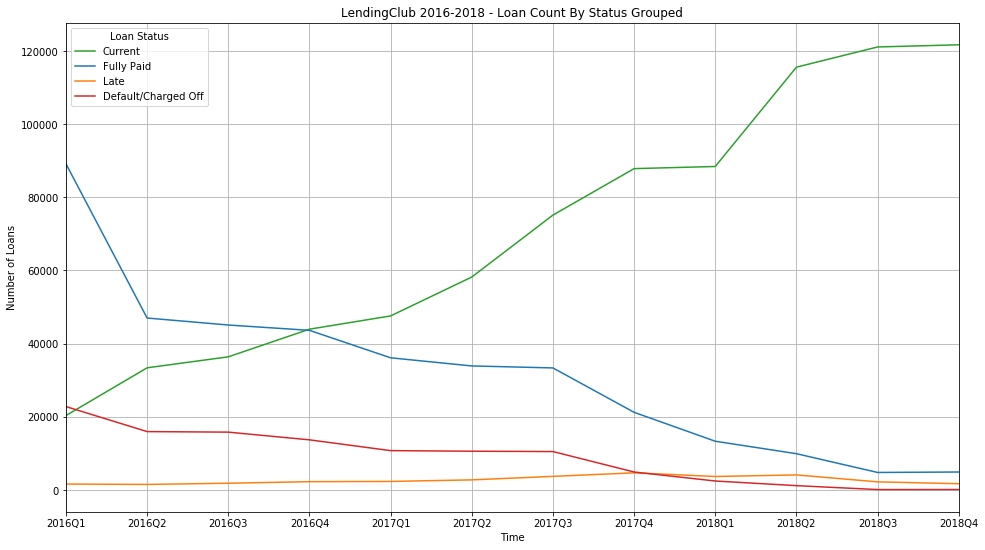

In [10]:
# Line plot of loan count by status grouped
plt.figure(figsize=(16,9))

colors = {
    "Current"             : "#2ca02c",
    "Fully Paid"          : "#1f77b4",
    "Late"                : "#ff7f0e",
    "Default/Charged Off" : "#d62728"    
}

x = list(range(len(dataset_loans)))
for loan_status, loan_status_count_list in loan_count_by_status_per_quarter_grouped.items():
    plt.plot(x, loan_status_count_list, label=loan_status, color=colors[loan_status])
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Status")
plt.title("LendingClub 2016-2018 - Loan Count By Status Grouped")
plt.savefig("res/LendingClub 2016-2018 - Loan Count By Status Grouped Line Plot.png", bbox_inches='tight')
plt.show()

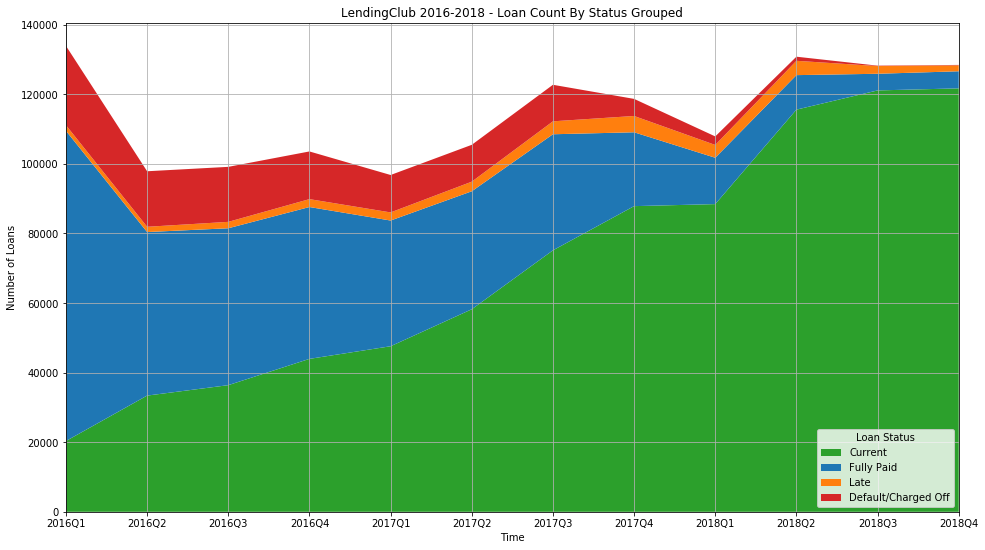

In [11]:
# Stacked area plot of loan count by status grouped
plt.figure(figsize=(16,9))

colors = {
    "Current"             : "#2ca02c",
    "Fully Paid"          : "#1f77b4",
    "Late"                : "#ff7f0e",
    "Default/Charged Off" : "#d62728"    
}

x = list(range(len(dataset_loans)))
plt.stackplot(x, *loan_count_by_status_per_quarter_grouped.values(), baseline="zero", labels=_loan_status_labels_grouped, colors=colors.values())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Status", loc=4)
plt.title("LendingClub 2016-2018 - Loan Count By Status Grouped")
plt.savefig("res/LendingClub 2016-2018 - Loan Count By Status Grouped Stacked Area Plot.png", bbox_inches='tight')
plt.show()

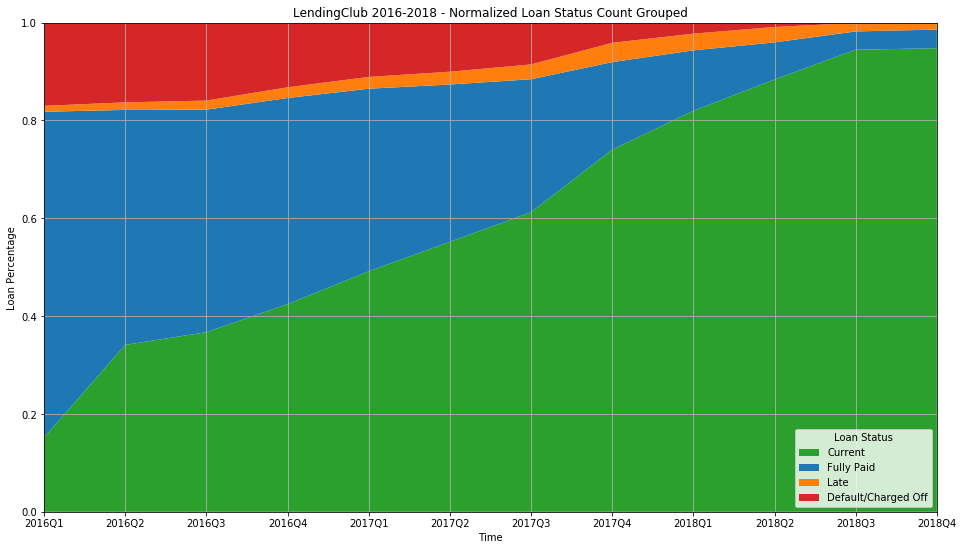

In [12]:
# Normalize loan count by status grouped
loan_status_percent_per_quarter_grouped = {loan_status: [loan_status_grouped_count / loan_status_grouped_count_total for loan_status_grouped_count, loan_status_grouped_count_total in zip(loan_status_count_list, [len(df) for df in dataset_loans.values()])] for loan_status, loan_status_count_list in loan_count_by_status_per_quarter_grouped.items()}

# Stacked area plot of normalized loan status count grouped
plt.figure(figsize=(16,9))

colors = {
    "Current"             : "#2ca02c",
    "Fully Paid"          : "#1f77b4",
    "Late"                : "#ff7f0e",
    "Default/Charged Off" : "#d62728"    
}

x = list(range(len(dataset_loans)))
plt.stackplot(x, *loan_status_percent_per_quarter_grouped.values(), baseline="zero", labels=_loan_status_labels_grouped, colors=colors.values())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0, top=1.0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Loan Percentage")
plt.legend(title="Loan Status", loc=4)
plt.title("LendingClub 2016-2018 - Normalized Loan Status Count Grouped")
plt.savefig("res/LendingClub 2016-2018 - Normalized Loan Status Count Grouped.png", bbox_inches='tight')
plt.show()

### Loan Amount By Loan Status

In [13]:
# Calculate loan amount by loan status
loan_status_loan_amount_per_quarter = {x: [0] * len(dataset_loans) for x in _loan_status_labels}

for idx, df in enumerate(dataset_loans.values()):
    loan_status_groups = df.groupby("loan_status", sort=False)
    for loan_status in loan_status_groups.groups.keys():
        loan_status_indexes = get_indexes(loan_status_groups, [loan_status])
        loan_status_loan_amount_per_quarter[loan_status][idx] = sum(df.loc[loan_status_indexes]["loan_amnt"])

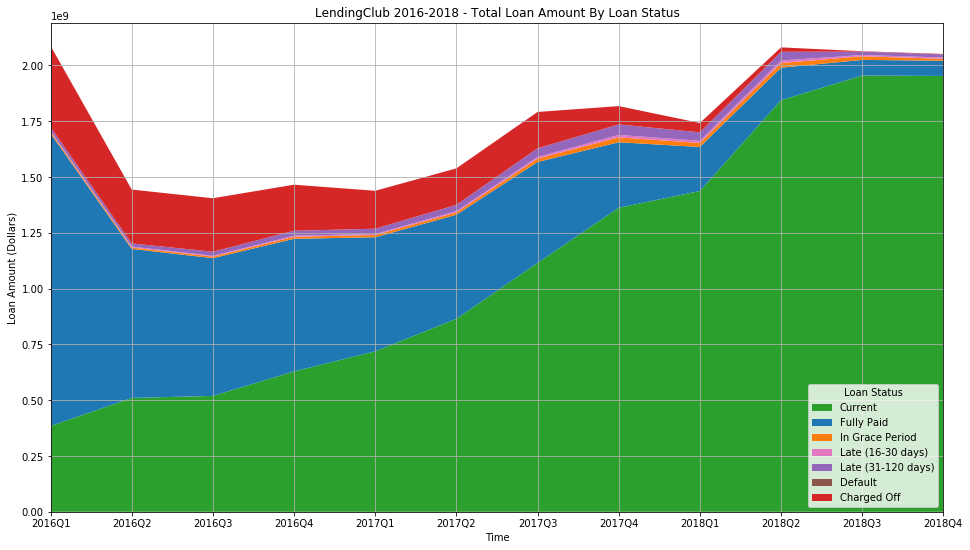

In [14]:
# Stacked area plot of total loan amount by loan status
plt.figure(figsize=(16,9))

colors = {
    "Current"            : "#2ca02c",
    "Fully Paid"         : "#1f77b4",
    "In Grace Period"    : "#ff7f0e",
    "Late (16-30 days)"  : "#e377c2",
    "Late (31-120 days)" : "#9467bd",
    "Default"            : "#8c564b",
    "Charged Off"        : "#d62728"    
}

x = list(range(len(dataset_loans)))
plt.stackplot(x, *loan_status_loan_amount_per_quarter.values(), baseline="zero", labels=_loan_status_labels, colors=colors.values())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Loan Amount (Dollars)")
plt.legend(title="Loan Status", loc=4)
plt.title("LendingClub 2016-2018 - Total Loan Amount By Loan Status")
plt.savefig("res/LendingClub 2016-2018 - Total Loan Amount By Loan Status.png", bbox_inches='tight')
plt.show()

### Loan Amount By Loan Status - Grouped

In [15]:
# Combine loan status labels
# Late = In Grace Period + Late (16-30 days) + Late (31-120 days)
# Default/Charged Off = Default + Charged Off
_loan_status_labels_grouped = ["Current", "Fully Paid", "Late", "Default/Charged Off"]

loan_status_loan_amount_per_quarter_grouped = {
    "Current": loan_status_loan_amount_per_quarter["Current"],
    "Fully Paid": loan_status_loan_amount_per_quarter["Fully Paid"],
    "Late": [sum([in_grace_period, late16, late30]) for in_grace_period, late16, late30 in zip(loan_status_loan_amount_per_quarter["In Grace Period"], loan_status_loan_amount_per_quarter["Late (16-30 days)"], loan_status_loan_amount_per_quarter["Late (31-120 days)"])],
    "Default/Charged Off": [sum([default, charged_off]) for default, charged_off in zip(loan_status_loan_amount_per_quarter["Default"], loan_status_loan_amount_per_quarter["Charged Off"])]
}

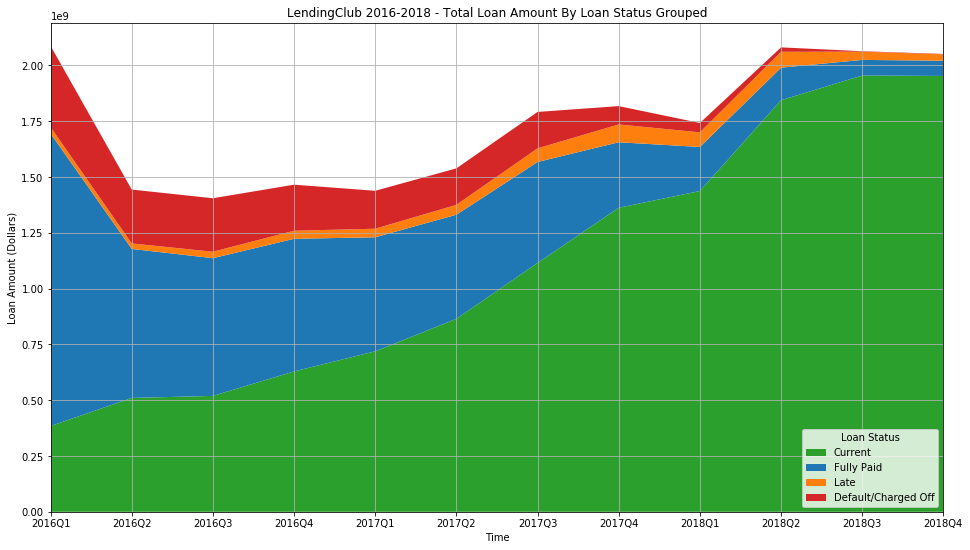

In [16]:
# Stacked area plot of total loan amount by loan status grouped
plt.figure(figsize=(16,9))

colors = {
    "Current"             : "#2ca02c",
    "Fully Paid"          : "#1f77b4",
    "Late"                : "#ff7f0e",
    "Default/Charged Off" : "#d62728"    
}

x = list(range(len(dataset_loans)))
plt.stackplot(x, *loan_status_loan_amount_per_quarter_grouped.values(), baseline="zero", labels=_loan_status_labels_grouped, colors=colors.values())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Loan Amount (Dollars)")
plt.legend(title="Loan Status", loc=4)
plt.title("LendingClub 2016-2018 - Total Loan Amount By Loan Status Grouped")
plt.savefig("res/LendingClub 2016-2018 - Total Loan Amount By Loan Status Grouped.png", bbox_inches='tight')
plt.show()

### Current Loan Count By Verification Status

In [17]:
_verification_status_labels = ["Source Verified", "Verified", "Not Verified"]

In [18]:
# Calculate current loan count by verification status
current_loan_verification_status_count_per_quarter = {k:[] for k in _verification_status_labels}

for df in dataset_loans.values():
    for verification_status, verification_status_count in df[df["loan_status"] == "Current"]["verification_status"].value_counts().iteritems():
        current_loan_verification_status_count_per_quarter[verification_status].append(verification_status_count)

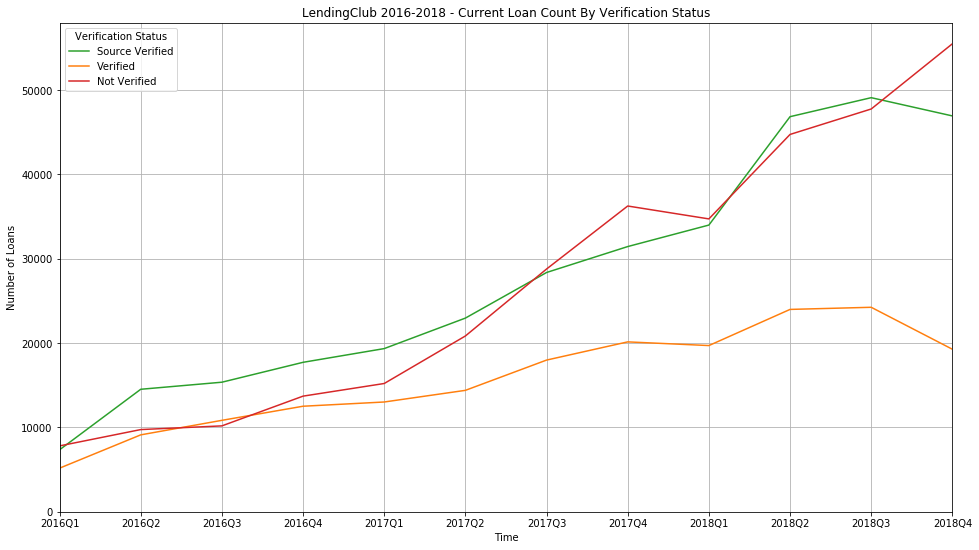

In [19]:
# Line plot of current loan count by verification statusd
plt.figure(figsize=(16,9))

colors = {
    "Source Verified" : "#2ca02c",
    "Verified"        : "#ff7f0e",
    "Not Verified"    : "#d62728",
}

x = list(range(len(dataset_loans)))
for verification_status, current_loan_verification_status_count_list in current_loan_verification_status_count_per_quarter.items():
    plt.plot(x, current_loan_verification_status_count_list, label=verification_status, color=colors[verification_status])
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Verification Status")
plt.title("LendingClub 2016-2018 - Current Loan Count By Verification Status")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Count By Verification Status Line Plot.png", bbox_inches='tight')
plt.show()

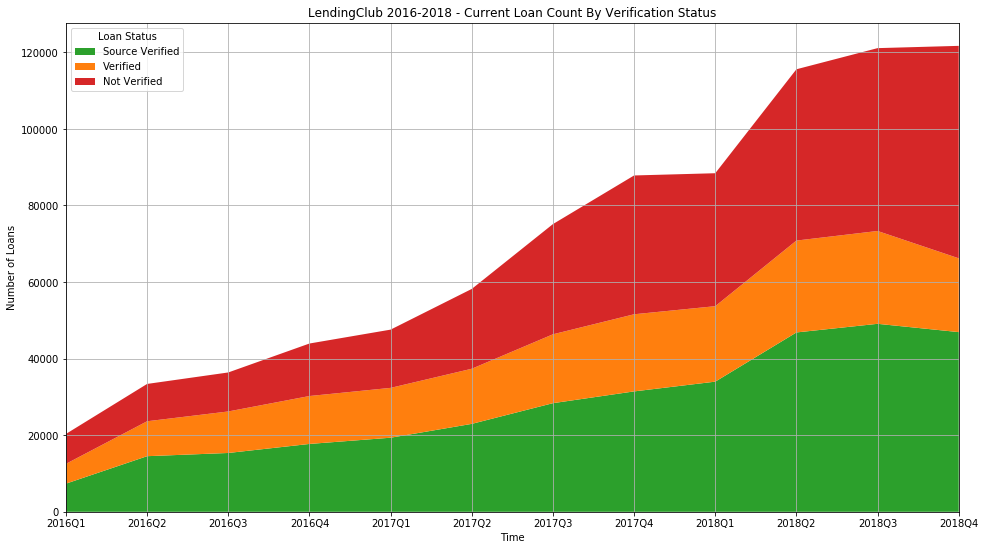

In [20]:
# Stacked area plot of current loan count by verification status
plt.figure(figsize=(16,9))

colors = {
    "Source Verified" : "#2ca02c",
    "Verified"        : "#ff7f0e",
    "Not Verified"    : "#d62728",
}

x = list(range(len(dataset_loans)))
plt.stackplot(x, *current_loan_verification_status_count_per_quarter.values(), baseline="zero", labels=_verification_status_labels, colors=colors.values())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Status", loc=2)
plt.title("LendingClub 2016-2018 - Current Loan Count By Verification Status")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Count By Verification Status Stacked Area Plot.png", bbox_inches='tight')
plt.show()

### Current Loan Amount By Verification Status

In [21]:
# Calculate current loan amount by verification status
current_loan_amount_by_verification_status_per_quarter = {x: [0] * len(dataset_loans) for x in _verification_status_labels}

for idx, df in enumerate(dataset_loans.values()):
    df = df[df["loan_status"] == "Current"]
    verification_status_groups = df.groupby("verification_status", sort=False)
    for verification_status in verification_status_groups.groups.keys():
        verification_status_indexes = get_indexes(verification_status_groups, [verification_status])
        current_loan_amount_by_verification_status_per_quarter[verification_status][idx] = sum(df.loc[verification_status_indexes]["loan_amnt"])

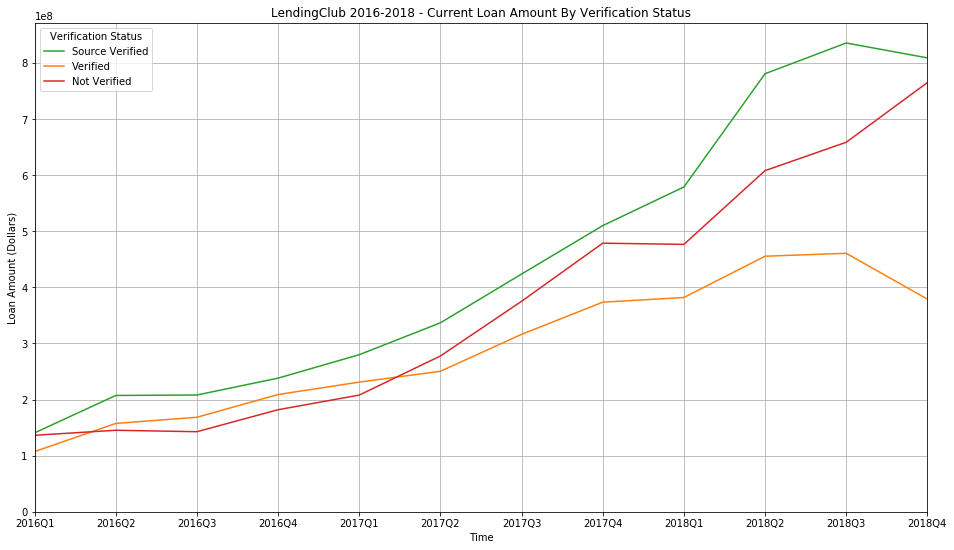

In [22]:
# Line plot of current loan amount by verification status
plt.figure(figsize=(16,9))

colors = {
    "Source Verified" : "#2ca02c",
    "Verified"        : "#ff7f0e",
    "Not Verified"    : "#d62728",
}

x = list(range(len(dataset_loans)))
for verification_status, current_loan_amount_by_verification_status_list in current_loan_amount_by_verification_status_per_quarter.items():
    plt.plot(x, current_loan_amount_by_verification_status_list, label=verification_status, color=colors[verification_status])
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Loan Amount (Dollars)")
plt.legend(title="Verification Status")
plt.title("LendingClub 2016-2018 - Current Loan Amount By Verification Status")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Amount By Verification Status Line Plot.png", bbox_inches='tight')
plt.show()

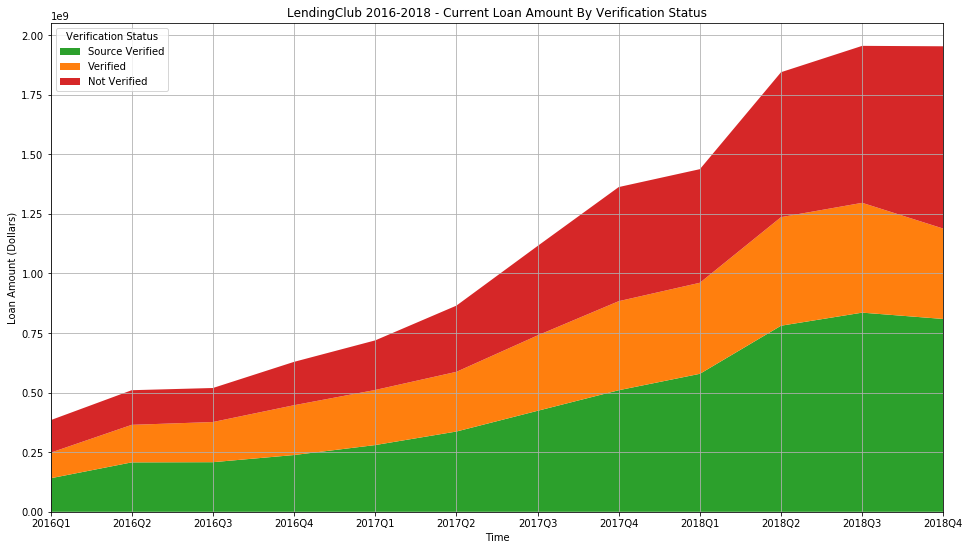

In [23]:
# Stacked area plot of current loan amount by verification status
plt.figure(figsize=(16,9))

colors = {
    "Source Verified" : "#2ca02c",
    "Verified"        : "#ff7f0e",
    "Not Verified"    : "#d62728",
}

x = list(range(len(dataset_loans)))
plt.stackplot(x, *current_loan_amount_by_verification_status_per_quarter.values(), baseline="zero", labels=_verification_status_labels, colors=colors.values())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Loan Amount (Dollars)")
plt.legend(title="Verification Status", loc=2)
plt.title("LendingClub 2016-2018 - Current Loan Amount By Verification Status")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Amount By Verification Status Stacked Area Plot.png", bbox_inches='tight')
plt.show()

### Current Loan Count By Grade

In [24]:
# Calculate current loan count by grade
current_loan_count_by_grade_per_quarter = {grade:[] for grade in list("ABCDEFG")}

for df in dataset_loans.values():
    for loan_grade, loan_grade_count in df[df["loan_status"] == "Current"]["grade"].value_counts().iteritems():
        current_loan_count_by_grade_per_quarter[loan_grade].append(loan_grade_count)

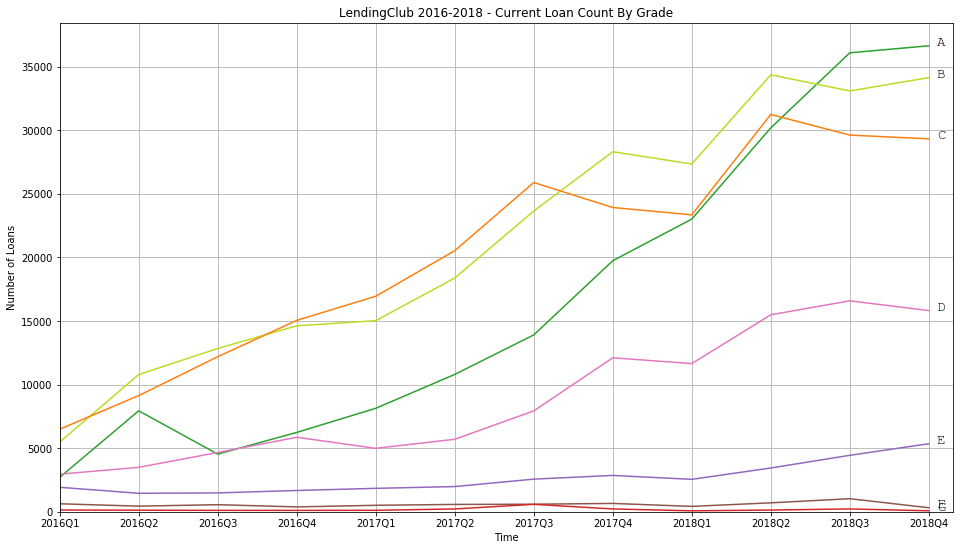

In [25]:
# Line plot of current loan count by grade
plt.figure(figsize=(16,9))

colors = {
    "A" : "#2ca02c",
    "B" : "#bcdb22",
    "C" : "#ff7f0e",
    "D" : "#e377c2",
    "E" : "#9467bd",
    "F" : "#8c564b",
    "G" : "#d62728"
}

x = list(range(len(dataset_loans)))
for loan_grade, current_loan_count_by_grade_list in current_loan_count_by_grade_per_quarter.items():
    plt.plot(x, current_loan_count_by_grade_list, label=loan_grade, color=colors[loan_grade])
    plt.annotate(loan_grade, xy=(x[-1] + 0.1, current_loan_count_by_grade_list[-1]), fontname="Courier New", fontsize=14)
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=x[-1] + 0.3)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
# plt.legend(title="Loan Grade", loc=2)
plt.title("LendingClub 2016-2018 - Current Loan Count By Grade")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Count By Grade.png", bbox_inches='tight')
plt.show()

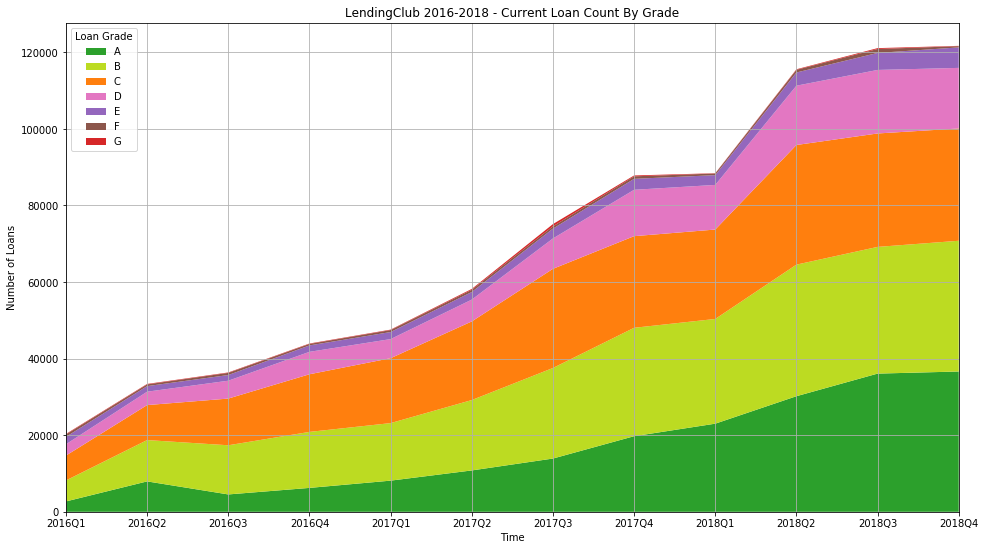

In [26]:
# Stacked area plot of current loan count by grade
plt.figure(figsize=(16,9))

colors = {
    "A" : "#2ca02c",
    "B" : "#bcdb22",
    "C" : "#ff7f0e",
    "D" : "#e377c2",
    "E" : "#9467bd",
    "F" : "#8c564b",
    "G" : "#d62728"
}

x = list(range(len(dataset_loans)))
plt.stackplot(x, *current_loan_count_by_grade_per_quarter.values(), baseline="zero", labels=current_loan_count_by_grade_per_quarter.keys(), colors=colors.values())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Grade", loc=2)
plt.title("LendingClub 2016-2018 - Current Loan Count By Grade")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Count By Grade Stacked Area Plot.png", bbox_inches='tight')
plt.show()

### Current Loan Amount By Grade

In [27]:
# Calculate current loan amount by grade
current_loan_amount_by_grade_per_quarter = {grade: [0] * len(dataset_loans) for grade in list("ABCDEFG")}

for idx, df in enumerate(dataset_loans.values()):
    df = df[df["loan_status"] == "Current"]
    grade_groups = df.groupby("grade", sort=False)
    for grade in grade_groups.groups.keys():
        grade_indexes = get_indexes(grade_groups, [grade])
        current_loan_amount_by_grade_per_quarter[grade][idx] = sum(df.loc[grade_indexes]["loan_amnt"])

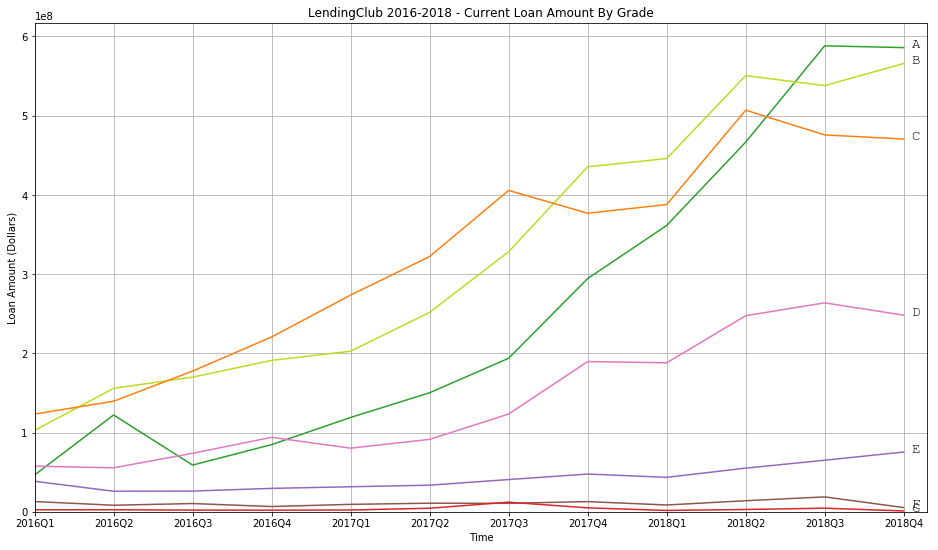

In [28]:
# Line plot of current loan amount by grade
plt.figure(figsize=(16,9))

colors = {
    "A" : "#2ca02c",
    "B" : "#bcdb22",
    "C" : "#ff7f0e",
    "D" : "#e377c2",
    "E" : "#9467bd",
    "F" : "#8c564b",
    "G" : "#d62728"
}

x = list(range(len(dataset_loans)))
for loan_grade, current_loan_amount_by_grade_list in current_loan_amount_by_grade_per_quarter.items():
    plt.plot(x, current_loan_amount_by_grade_list, label=loan_grade, color=colors[loan_grade])
    plt.annotate(loan_grade, xy=(x[-1] + 0.1, current_loan_amount_by_grade_list[-1]), fontname="Courier New", fontsize=14)
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=x[-1] + 0.3)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Loan Amount (Dollars)")
# plt.legend(title="Loan Grade", loc=2)
plt.title("LendingClub 2016-2018 - Current Loan Amount By Grade")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Amount By Grade.png", bbox_inches='tight')
plt.show()

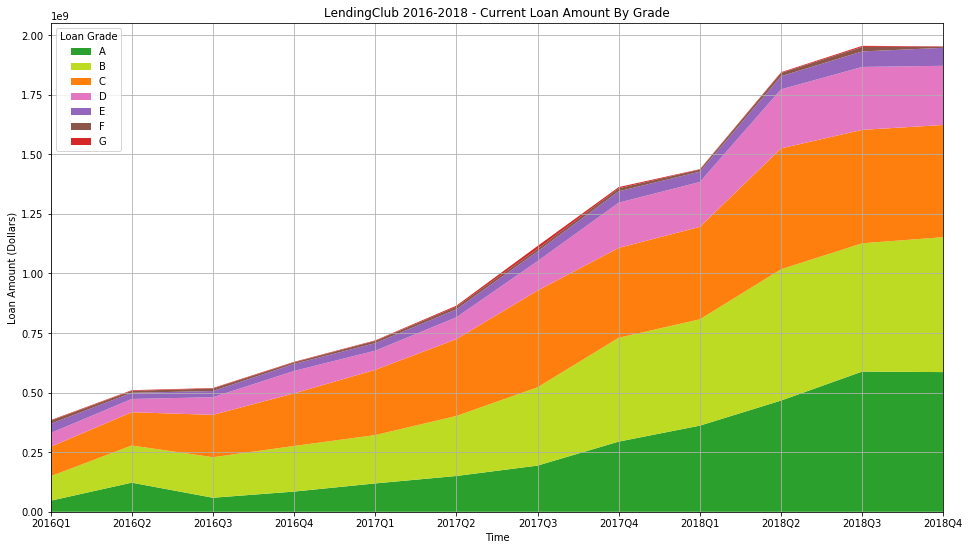

In [29]:
# Stacked area plot of current loan amount by grade
plt.figure(figsize=(16,9))

colors = {
    "A" : "#2ca02c",
    "B" : "#bcdb22",
    "C" : "#ff7f0e",
    "D" : "#e377c2",
    "E" : "#9467bd",
    "F" : "#8c564b",
    "G" : "#d62728"
}

x = list(range(len(dataset_loans)))
plt.stackplot(x, *current_loan_amount_by_grade_per_quarter.values(), baseline="zero", labels=current_loan_amount_by_grade_per_quarter.keys(), colors=colors.values())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Loan Amount (Dollars)")
plt.legend(title="Loan Grade", loc=2)
plt.title("LendingClub 2016-2018 - Current Loan Amount By Grade")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Amount By Grade Stacked Area Plot.png", bbox_inches='tight')
plt.show()

### Current Loan Count By Title

In [30]:
_current_loan_titles = set()
for df in dataset_loans.values():
    _current_loan_titles = _current_loan_titles.union(set(df[df["loan_status"] == "Current"]["title"].value_counts().keys()))

In [31]:
# Calculate current loan count by title
current_loan_count_by_title_per_quarter = {current_loan_title: [0] * len(dataset_loans) for current_loan_title in _current_loan_titles}
for idx, df in enumerate(dataset_loans.values()):
    for current_loan_title, current_loan_title_count in df[df["loan_status"] == "Current"]["title"].value_counts().iteritems():
        current_loan_count_by_title_per_quarter[current_loan_title][idx] += current_loan_title_count

# Sort in descending order by mean
ordered_loan_titles = [(mean(current_loan_title_count_list), current_loan_title) for current_loan_title, current_loan_title_count_list in current_loan_count_by_title_per_quarter.items()]
ordered_loan_titles.sort(reverse=True)

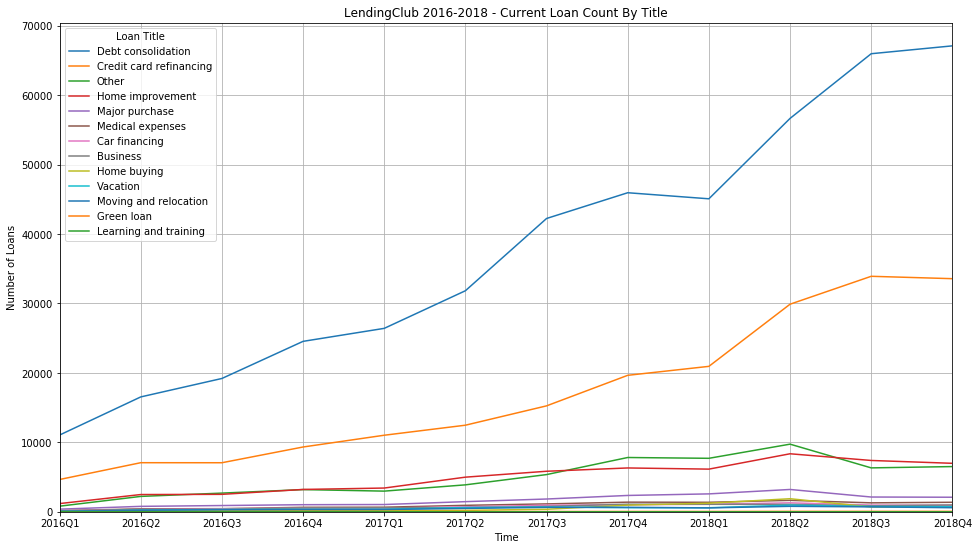

In [32]:
# Line plot of current loan count by title
plt.figure(figsize=(16,9))

x = list(range(len(dataset_loans)))
for _, current_loan_title in ordered_loan_titles:
    plt.plot(x, current_loan_count_by_title_per_quarter[current_loan_title], label=current_loan_title)
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title")
plt.title("LendingClub 2016-2018 - Current Loan Count By Title")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Count By Title Line Plot.png", bbox_inches='tight')
plt.show()

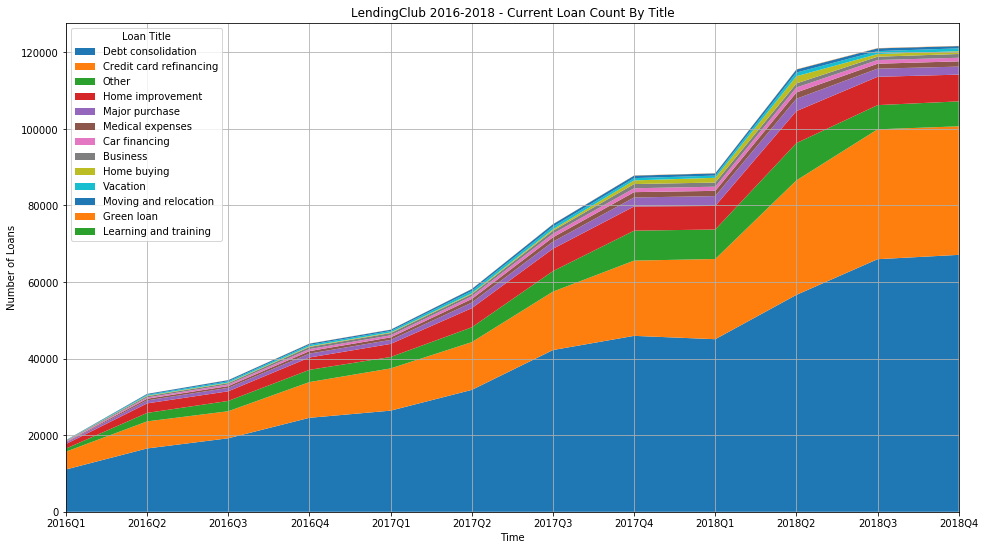

In [33]:
# Stacked area plot of current loan count by title
plt.figure(figsize=(16,9))

x = list(range(len(dataset_loans)))
plt.stackplot(x, *[current_loan_count_by_title_per_quarter[current_loan_title] for _, current_loan_title in ordered_loan_titles], baseline="zero", labels=[current_loan_title for _, current_loan_title in ordered_loan_titles])
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title", loc=2)
plt.title("LendingClub 2016-2018 - Current Loan Count By Title")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Count By Title Stacked Area Plot.png", bbox_inches='tight')
plt.show()

### Current Loan Amount By Title

In [34]:
# Calculate current loan amount by title
current_loan_amount_by_title_per_quarter = {current_loan_title: [0] * len(dataset_loans) for current_loan_title in _current_loan_titles}

for idx, df in enumerate(dataset_loans.values()):
    df = df[df["loan_status"] == "Current"]
    title_groups = df.groupby("title", sort=False)
    for title in title_groups.groups.keys():
        title_indexes = get_indexes(title_groups, [title])
        current_loan_amount_by_title_per_quarter[title][idx] = sum(df.loc[title_indexes]["loan_amnt"])

# Sort in descending order by mean
# The two lines below are commented to use the ordered_loan_titles from current loan count by title
# ordered_loan_titles = [(mean(current_loan_title_amount_list), current_loan_title) for current_loan_title, current_loan_title_amount_list in current_loan_amount_by_title_per_quarter.items()]
# ordered_loan_titles.sort(reverse=True)

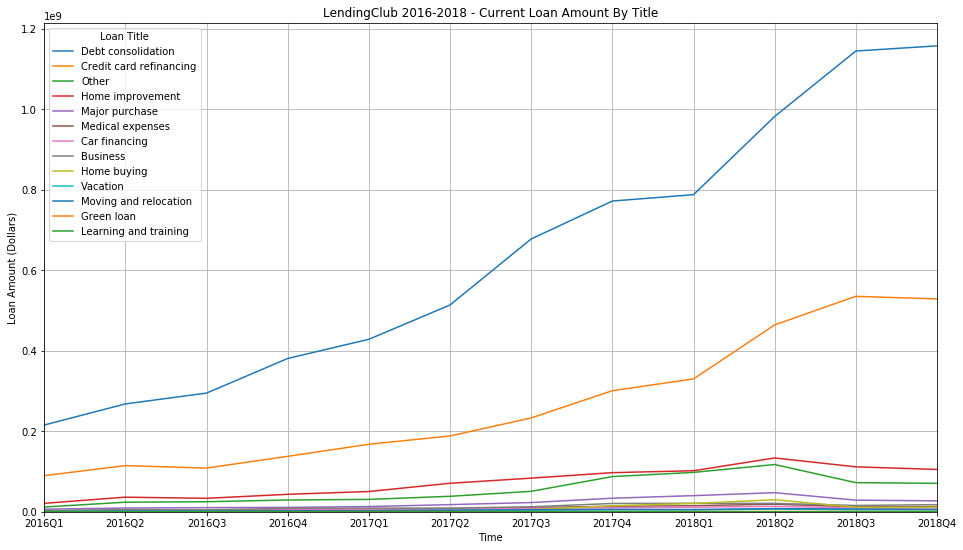

In [35]:
# Line plot of current loan amount by title
plt.figure(figsize=(16,9))

x = list(range(len(dataset_loans)))
for _, current_loan_title in ordered_loan_titles:
    plt.plot(x, current_loan_amount_by_title_per_quarter[current_loan_title], label=current_loan_title)
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Loan Amount (Dollars)")
plt.legend(title="Loan Title")
plt.title("LendingClub 2016-2018 - Current Loan Amount By Title")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Amount By Title Line Plot.png", bbox_inches='tight')
plt.show()

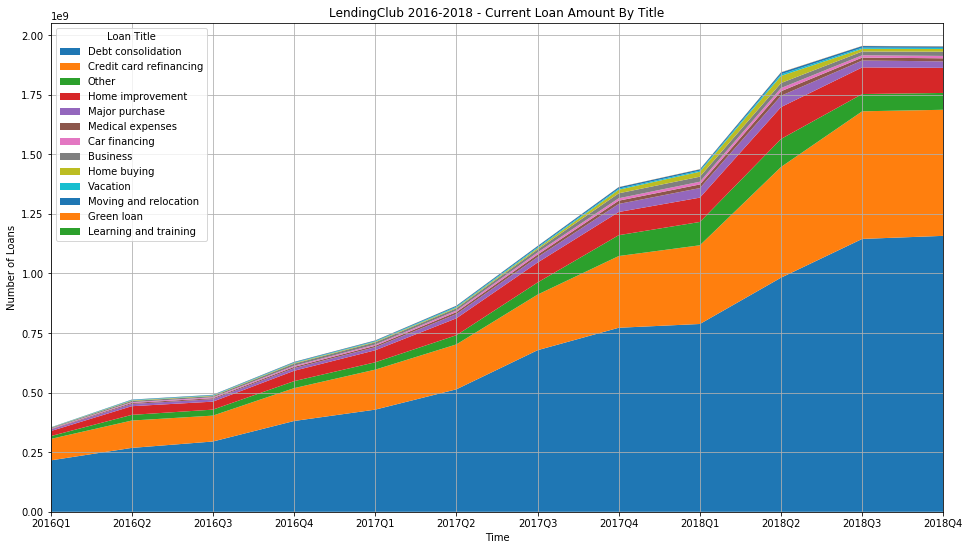

In [36]:
# Stacked area plot of current loan amount by title
plt.figure(figsize=(16,9))

x = list(range(len(dataset_loans)))
plt.stackplot(x, *[current_loan_amount_by_title_per_quarter[current_loan_title] for _, current_loan_title in ordered_loan_titles], baseline="zero", labels=[current_loan_title for _, current_loan_title in ordered_loan_titles])
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title", loc=2)
plt.title("LendingClub 2016-2018 - Current Loan Amount By Title")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Amount By Title Stacked Area Plot.png", bbox_inches='tight')
plt.show()

### Current Loan Count By Title - Grouped

In [37]:
# Combine current loan titles
# Keep top three loan titles
# Other = everything else not in top three
_current_loan_titles_grouped = ["Debt consolidation", "Credit card refinancing", "Home improvement", "Other"]

current_loan_count_by_title_per_quarter_grouped = {x: [0] * len(dataset_loans) for x in _current_loan_titles_grouped}

for idx, df in enumerate(dataset_loans.values()):
    for current_loan_title, current_loan_by_title_count in df[df["loan_status"] == "Current"]["title"].value_counts().iteritems():
        if current_loan_title in _current_loan_titles_grouped:
            current_loan_count_by_title_per_quarter_grouped[current_loan_title][idx] += current_loan_by_title_count
            continue
        current_loan_count_by_title_per_quarter_grouped["Other"][idx] += current_loan_by_title_count


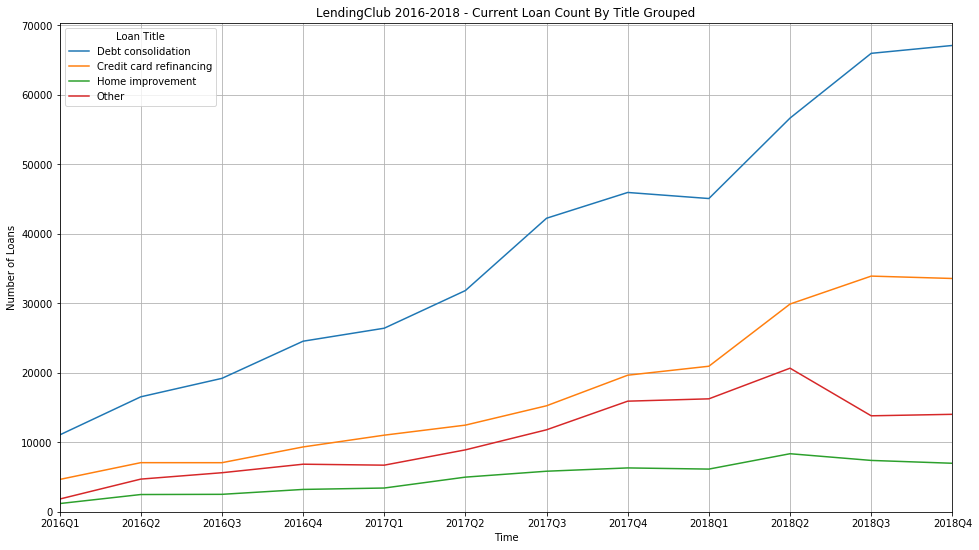

In [38]:
# Line plot of current loan count by title grouped
plt.figure(figsize=(16,9))

x = list(range(len(dataset_loans)))
for current_loan_title, current_loan_count_by_title_list in current_loan_count_by_title_per_quarter_grouped.items():
    plt.plot(x, current_loan_count_by_title_list, label=current_loan_title)
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title")
plt.title("LendingClub 2016-2018 - Current Loan Count By Title Grouped")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Count By Title Grouped Line Plot.png", bbox_inches='tight')
plt.show()

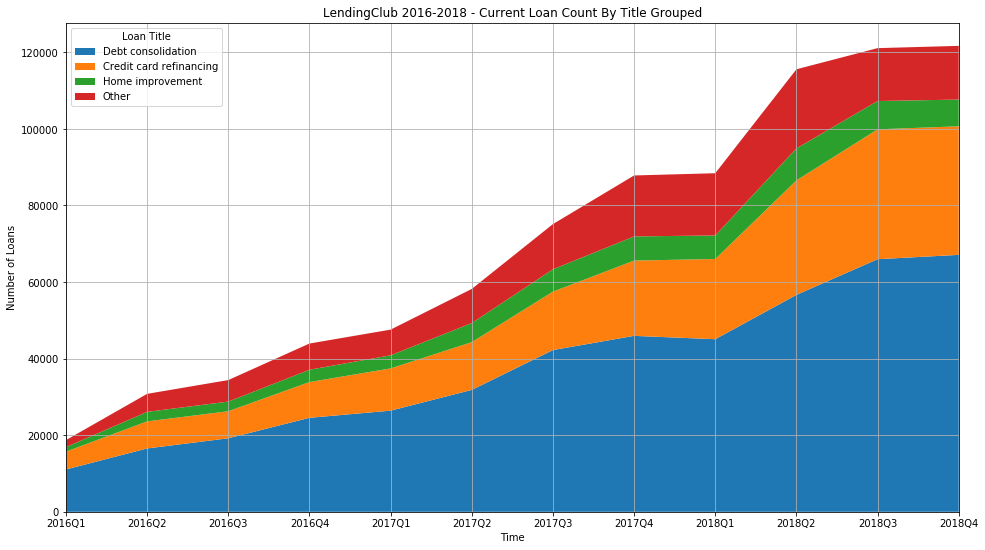

In [39]:
# Stacked area plot of current loan count by title grouped
plt.figure(figsize=(16,9))

x = list(range(len(dataset_loans)))
plt.stackplot(x, *current_loan_count_by_title_per_quarter_grouped.values(), baseline="zero", labels=current_loan_count_by_title_per_quarter_grouped.keys())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title", loc=2)
plt.title("LendingClub 2016-2018 - Current Loan Count By Title Grouped")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Count By Title Grouped Stacked Area Plot.png", bbox_inches='tight')
plt.show()

### Current Loan Amount By Title - Grouped

In [40]:
# Calculate current loan amount by title grouped
current_loan_amount_by_title_per_quarter_grouped = {current_loan_title: [0] * len(dataset_loans) for current_loan_title in _current_loan_titles_grouped}

for idx, df in enumerate(dataset_loans.values()):
    df = df[df["loan_status"] == "Current"]
    title_groups = df.groupby("title", sort=False)
    for title in title_groups.groups.keys():
        title_indexes = get_indexes(title_groups, [title])
        if title in _current_loan_titles_grouped:
            current_loan_amount_by_title_per_quarter_grouped[title][idx] = sum(df.loc[title_indexes]["loan_amnt"])
            continue
        current_loan_amount_by_title_per_quarter_grouped["Other"][idx] += sum(df.loc[title_indexes]["loan_amnt"])

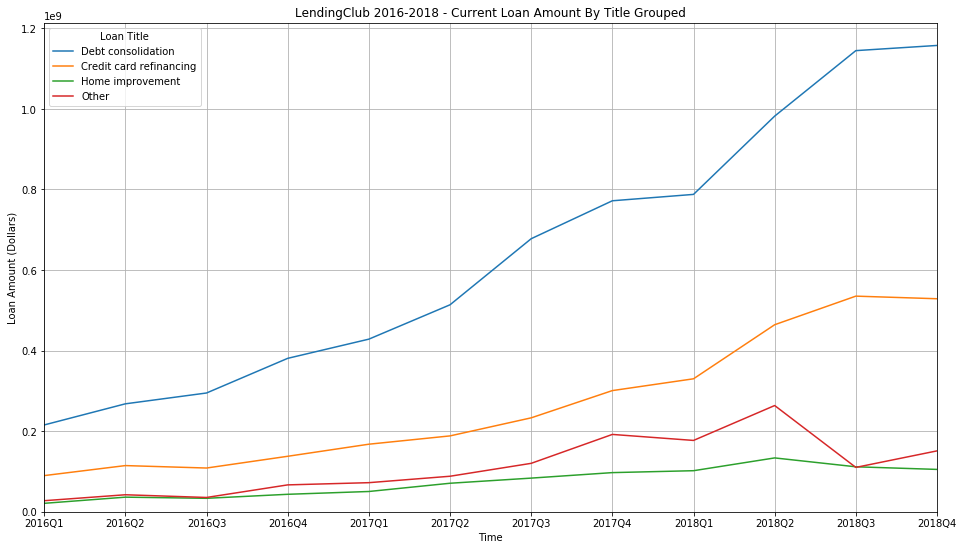

In [41]:
# Line plot of current loan amount by title grouped
plt.figure(figsize=(16,9))

x = list(range(len(dataset_loans)))
for current_loan_title, current_loan_amount_by_title_list in current_loan_amount_by_title_per_quarter_grouped.items():
    plt.plot(x, current_loan_amount_by_title_list, label=current_loan_title)
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Loan Amount (Dollars)")
plt.legend(title="Loan Title")
plt.title("LendingClub 2016-2018 - Current Loan Amount By Title Grouped")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Amount By Title Grouped Line Plot.png", bbox_inches='tight')
plt.show()

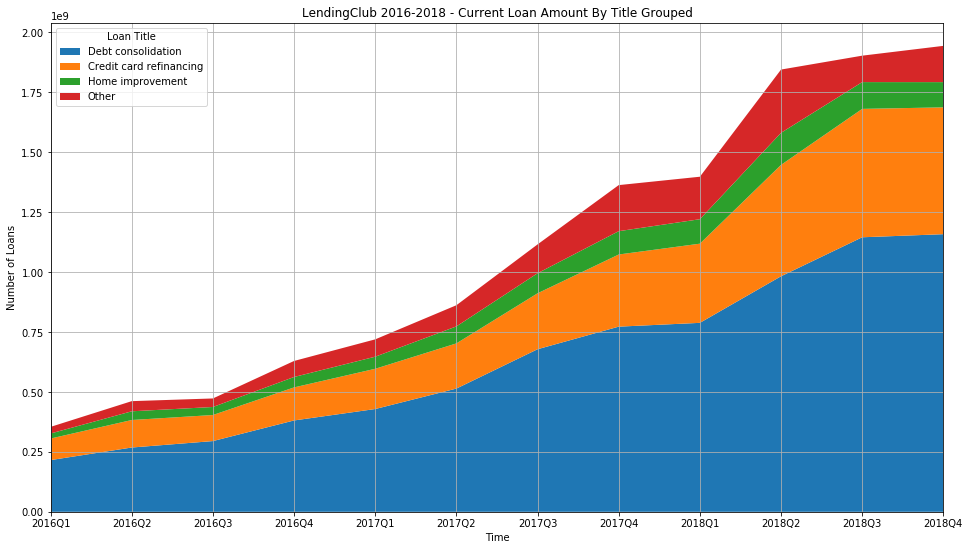

In [42]:
# Stacked area plot of current loan amount by title grouped
plt.figure(figsize=(16,9))

x = list(range(len(dataset_loans)))
plt.stackplot(x, *current_loan_amount_by_title_per_quarter_grouped.values(), baseline="zero", labels=current_loan_amount_by_title_per_quarter_grouped.keys())
plt.xticks(ticks=x, labels=dataset_loans.keys())
plt.xlim(left=0, right=len(dataset_loans) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title", loc=2)
plt.title("LendingClub 2016-2018 - Current Loan Amount By Title Grouped")
plt.savefig("res/LendingClub 2016-2018 - Current Loan Amount By Title Grouped Stacked Area Plot.png", bbox_inches='tight')
plt.show()